1  err (any) median closed:  91.6
2  err < 10% median closed:  91.4
                                     count  percent  stage_num
sample              asm_unit sex                              
HG00514.vrk-ps-sseq asm-hap1 female    136    23.41          3
                    asm-hap2 female    160    27.54          3
3  err < 1% median closed:  88.8
4  err < 0.1% median closed:  33.4
Global median of median gap lengths: 20708


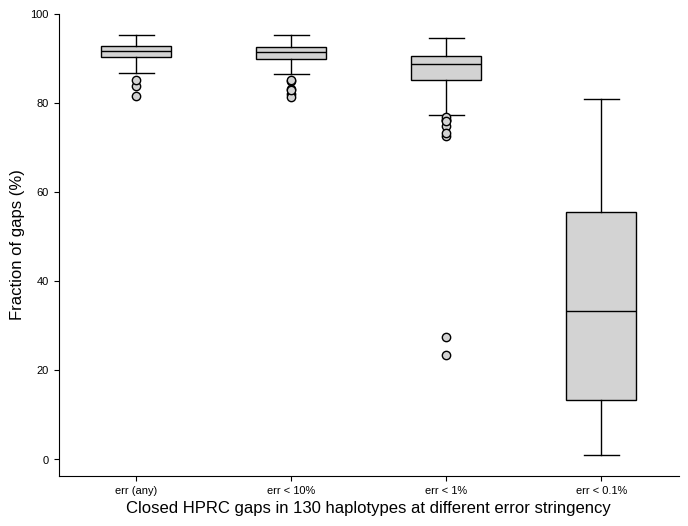

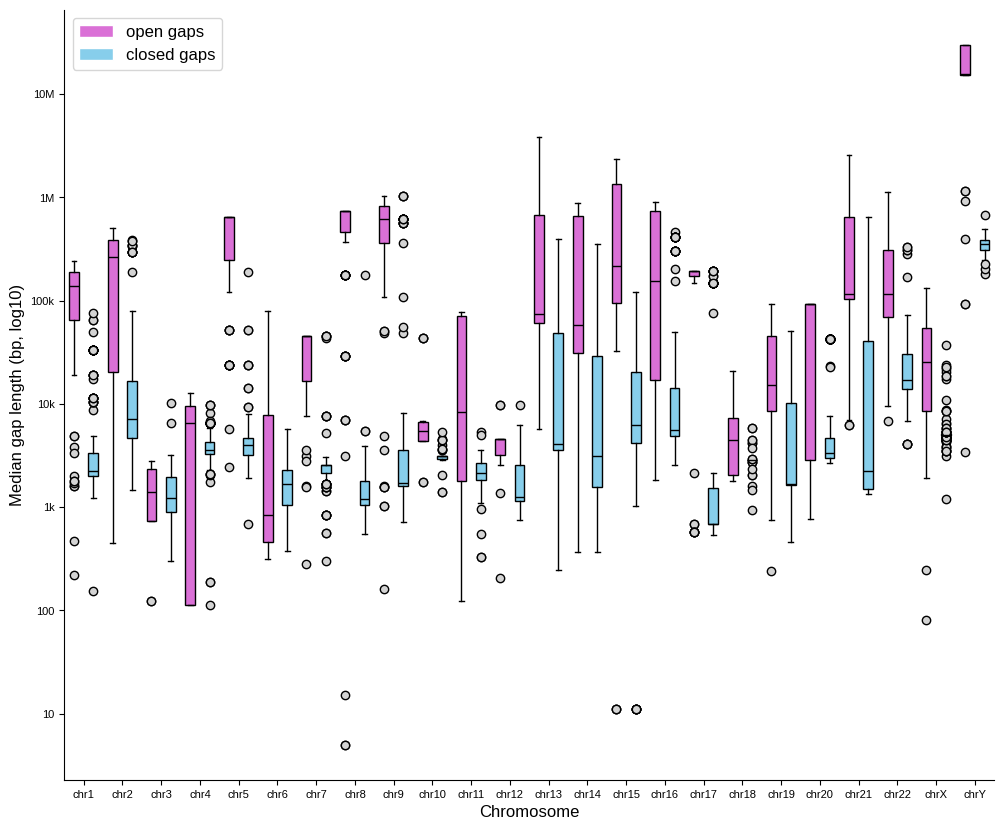

In [3]:
import pathlib
import functools
import statistics
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

%cd -q "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/notebooks"

raise RuntimeError(
    (
        "NOTEBOOK IS DEPRECATED - "
        "run notebooks notebooks/tables/dump-hprc-gap-table.ipynb "
        "& /notebooks/plotting/fig_supp/hprc-gap-closing-stats.ipynb"
    )
)

_PROJECT_CONFIG_NB = str(pathlib.Path("00_project_config.ipynb").resolve(strict=True))
_PLOT_CONFIG_NB = str(pathlib.Path("05_plot_config.ipynb").resolve(strict=True))

%run $_PROJECT_CONFIG_NB
%run $_PLOT_CONFIG_NB

_MYNAME="hprc-gap-summary"
_MYSTAMP=get_nb_stamp(_MYNAME)

_MY_OUT_PATH = PLOT_OUT_SUPPL_FIG.joinpath("hprc_gaps")

summary_file = PROJECT_DATA_ROOT.joinpath(
    "2024_assm_breaks",
    "SAMPLES.vrk-ps-sseq.t2tv2.hprc-gaps.summary.tsv"
)

gaps = pd.read_csv(summary_file, sep="\t", header=0)


def prep_closing_stats(gaps):

    proc = gaps.loc[gaps["chrom"] == "genome", :].copy()
    cmp_stages = [
        "not_closed", "closed_at_err_any",
        "closed_at_err_lst_10pct", "closed_at_err_lst_1pct",
        "closed_at_err_lst_01pct"
    ]
    stage_labels = dict(
        (label, stage_num) for stage_num, label
        in enumerate(cmp_stages, start=0)
    )
    proc["stage"] = proc["max_stringency"].replace(stage_labels)

    count_stats = []
    for stage_num in sorted(stage_labels.values()):

        if stage_num == 0:
            global_totals = proc.groupby(["sample", "asm_unit", "sex"])["count"].sum()

        stage_counts = proc.loc[proc["stage"] >= stage_num, :].groupby(["sample", "asm_unit", "sex"])["count"].sum()
        stage_pct = (stage_counts / global_totals * 100).round(2).rename("percent")
        stage_df = pd.concat([stage_counts, stage_pct], axis=1, ignore_index=False)
        stage_df["stage_num"] = stage_num
        count_stats.append(stage_df)

    count_stats = pd.concat(count_stats, axis=0, ignore_index=False)

    return count_stats, cmp_stages


def prep_size_stats(gaps):

    proc = gaps.copy()
    cmp_stages = [
        "not_closed", "closed_at_err_any",
        "closed_at_err_lst_10pct", "closed_at_err_lst_1pct",
        "closed_at_err_lst_01pct"
    ]
    stage_labels = dict(
        (label, stage_num) for stage_num, label
        in enumerate(cmp_stages, start=0)
    )
    proc["stage"] = proc["max_stringency"].replace(stage_labels)

    return proc


closing_stats, closing_labels = prep_closing_stats(gaps)
size_stats = prep_size_stats(gaps)


def plot_size_stats(size_stats, skip_save=False):

    chrom_order = [f"chr{n}" for n in range(1,23)] + ["chrX", "chrY"]

    boxes = {"open": [], "closed": []}
    labels = []
    label_pos = []
    positions = {"open": [], "closed": []}

    select_open = size_stats["stage"] == 0
    select_closed = size_stats["stage"] >= 3

    pos = 0
    for chrom in chrom_order:
        select_chrom = size_stats["chrom"] == chrom
        is_open = select_open & select_chrom
        is_closed = select_closed & select_chrom

        boxes["open"].append(np.log10(size_stats.loc[is_open, "median_gap_length"].values))
        boxes["closed"].append(np.log10(size_stats.loc[is_closed, "median_gap_length"].values))
        pos += 1
        positions["open"].append(pos)
        label_pos.append(pos + 0.5)
        labels.append(chrom)
        pos += 1
        positions["closed"].append(pos)

    global_median = size_stats.loc[size_stats["chrom"] == "genome", "median_gap_length"].values
    global_median = statistics.median(global_median)
    print(f"Global median of median gap lengths: {global_median}")

    fig, ax = plt.subplots(figsize=(12,10))

    box_open = ax.boxplot(
        boxes["open"],
        notch=False,
        positions=positions["open"],
        boxprops={"facecolor": "orchid"},
    )

    box_close = ax.boxplot(
        boxes["closed"],
        notch=False,
        positions=positions["closed"],
        boxprops={"facecolor": "skyblue"},
    )

    ax.set_xticks(label_pos)
    ax.set_xticklabels(labels)

    color_legend = build_patch_legend([("open gaps", "orchid"), ("closed gaps", "skyblue")])
    ax.legend(handles=color_legend)

    ax.set_xlabel("Chromosome")
    ax.set_ylabel("Median gap length (bp, log10)")

    ax.set_yticks([1,2,3,4,5,6,7])
    ax.set_yticklabels(["10", "100", "1k", "10k", "100k", "1M", "10M"]) 

    if not skip_save:
    
        low_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-size.lowres.png")
        save_figure(low_res, fig)
        high_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-size.highres.png")
        save_figure(high_res, fig, dpi=300)
        pdf = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-size.pdf")
        save_figure(pdf, fig)
    
    return


def plot_closing_stats_per_stage(closing_stats, skip_save=False):

    closing_label = {
        1: "err (any)",
        2: "err < 10%",
        3: "err < 1%",
        4: "err < 0.1%"
    }

    boxes = []
    labels = []
    
    for stage_num in range(1,5):
        stats = closing_stats.loc[closing_stats["stage_num"] == stage_num, "percent"].values
        if stage_num == 3:
            print(closing_stats.loc[
                      (closing_stats["stage_num"] == stage_num) & (closing_stats["percent"] < 50), :
                      ]
                 )
        print(stage_num, f" {closing_label[stage_num]} median closed: ", round(statistics.median(stats), 1))
        boxes.append(stats)
        labels.append(closing_label[stage_num])

    fig, ax = plt.subplots(figsize=(8,6))

    boxplot = ax.boxplot(
        boxes,
        notch=False,
        tick_labels=labels,
        boxprops={"facecolor": "lightgrey"}
    )

    ax.set_xlabel("Closed HPRC gaps in 130 haplotypes at different error stringency")
    ax.set_ylabel("Fraction of gaps (%)")

    if not skip_save:
    
        low_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-err.lowres.png")
        save_figure(low_res, fig)
        high_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-err.highres.png")
        save_figure(high_res, fig, dpi=300)
        pdf = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-err.pdf")
        save_figure(pdf, fig)

    return

_ = plot_closing_stats_per_stage(closing_stats, True)
_ = plot_size_stats(size_stats, True)

    
    